<a href="https://colab.research.google.com/github/ShmatArtem/TMSds/blob/main/HW28_29_Shmat_Artem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU ,PReLU , LeakyReLU , ELU
from tensorflow.keras.layers import Dropout

from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
!pip install neptune-optuna
!pip install optuna
!pip install neptune
import optuna
import neptune
import neptune.integrations.optuna as npt_utils

EDA

In [2]:
df= pd.read_csv('CarPrice_Assignment.csv')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
df.shape

(205, 26)

In [4]:
long_cols = []
un_val = {}
for col in df.columns:
  if len(df[col].value_counts()) < 10:
    un_val[col] = df[col].value_counts()
  else:
    long_cols.append(col)

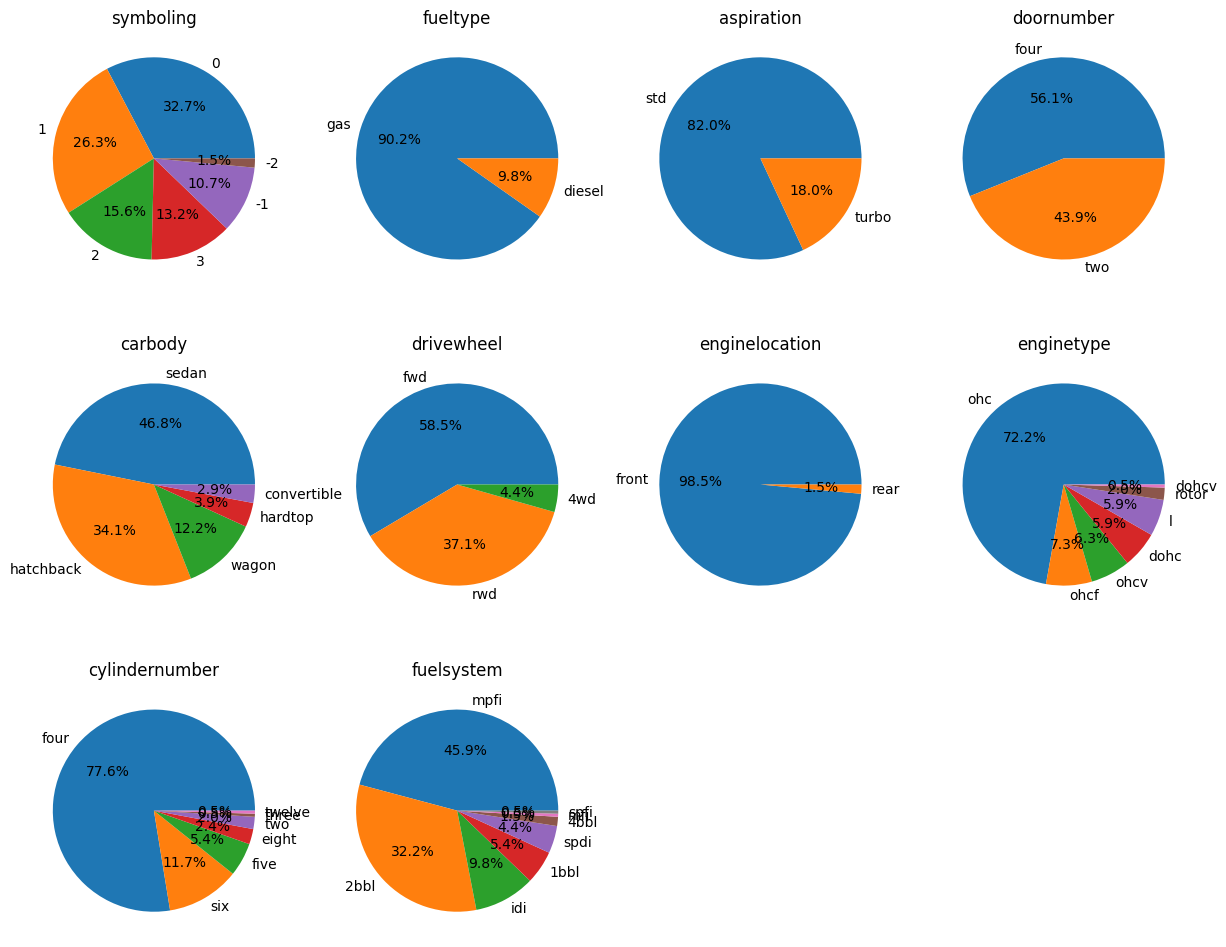

In [5]:
plt.figure(figsize = (15,12))
for i, col in enumerate(un_val):
  plt.subplot(3,4,i+1)
  plt.title(col)
  plt.pie(un_val[col], labels=un_val[col].index, autopct='%1.1f%%')

ВОПРОС: во многих фичах нарушен баланс классов, что с этим делать?
Пропускать или как-то урезать до примерно равного состояния

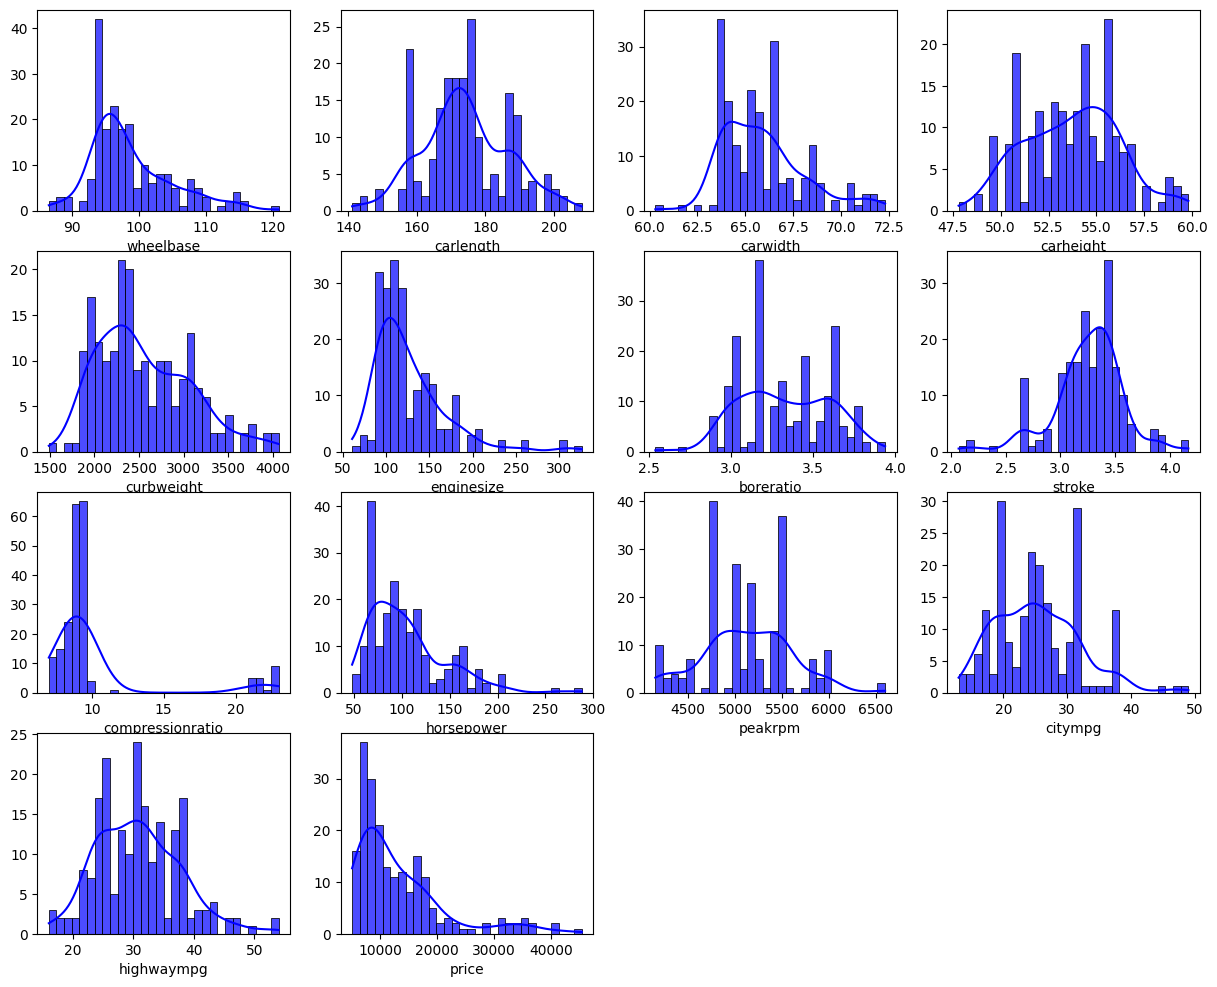

In [6]:
plt.figure(figsize = (15,12))
for i, col in enumerate(long_cols[2:]):
  plt.subplot(4,4,i+1)
  sns.histplot(df[col], kde=True, bins=30, color='blue', edgecolor='black', alpha=0.7)
  plt.xlabel(col)
  plt.ylabel('')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [8]:
df.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


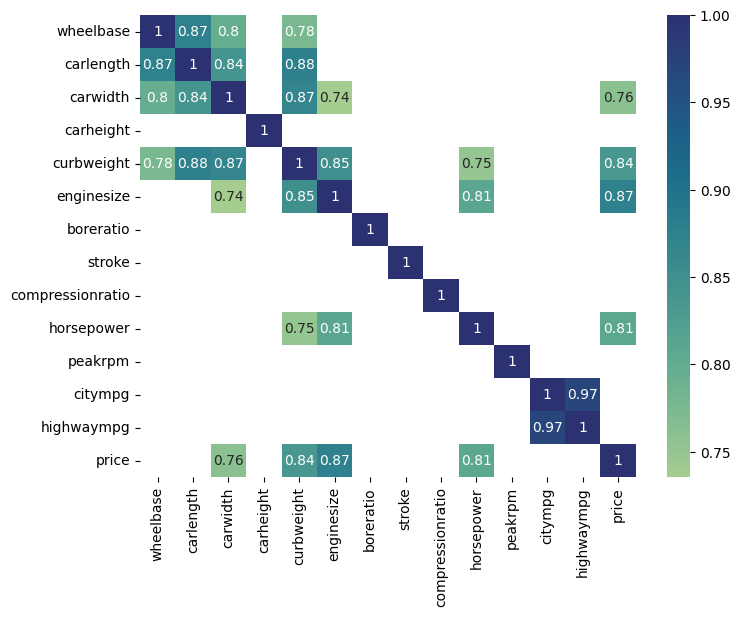

In [9]:
data = df[long_cols[2:]].corr()
plt.figure(figsize = (8,6))
sns.heatmap(data =data.abs()[data>0.7], annot = True, cmap= 'crest')
plt.show()

Исходя из матрици корреляции, целесообразно будет:
1. Объединить фичи citympg	highwaympg, так как это почти одна и та же инфа, плюс корреляция супер огромная
2. Ну и carlenth и carwidth взаимозависимы, одна из них сильно влияет на таргет, поэтому сделаем из них одну фичу



Preprocessing

In [10]:
df['mpg'] = df['citympg'] + df['highwaympg']
df['car_area'] = df['carlength'] * df['carwidth']

In [11]:
def split_func(brand):
  brand = brand.split(sep = ' ')[0].lower()
  return brand

In [12]:
def correct_func(brand):
    if brand == 'vw':
      brand = brand.replace('vw', 'volkswagen')
    elif brand == 'vokswagen':
      brand = brand.replace('vokswagen', 'volkswagen')
    elif brand == 'maxda':
      brand = brand.replace('maxda', 'mazda')
    elif brand == 'toyouta':
      brand = brand.replace('toyouta', 'toyota')
    elif brand == 'porcshce':
      brand = brand.replace('porcshce', 'porsche')
    return brand

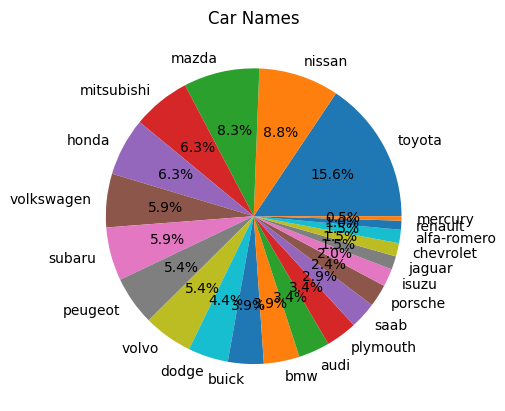

In [13]:
temp = df['CarName'].apply(split_func)
df['CarName'] = temp.apply(correct_func)
data = df['CarName'].value_counts()

plt.title('Car Names')
plt.pie(data.values, labels=data.index, autopct='%1.1f%%')
plt.show()

In [14]:
df = df.drop(['car_ID', 'carlength', 'carwidth', 'citympg', 'highwaympg'], axis =1)

In [29]:
for column in un_val:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
df['CarName'] = label_encoder.fit_transform(df['CarName'])

In [43]:
to_scale = ['wheelbase','carheight','curbweight','enginesize','boreratio','stroke','compressionratio','horsepower','peakrpm','mpg','car_area']

In [45]:
scaler = StandardScaler()

df_scaled = df.copy()
for column in to_scale:
    df_scaled[column] = scaler.fit_transform(df[[column]])

df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [47]:
df_scaled.iloc[:, 10:]

,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,price,mpg,car_area
0,-0.014566,0,2,0.074449,5,0.519071,-1.839377,-0.288349,0.174483,-0.262960,13495.0,-0.599325,-0.583626
1,-0.014566,0,2,0.074449,5,0.519071,-1.839377,-0.288349,0.174483,-0.262960,16500.0,-0.599325,-0.583626
2,0.514882,5,3,0.604046,5,-2.404880,0.685946,-0.288349,1.264536,-0.262960,16500.0,-0.824897,-0.242506
3,-0.420797,3,2,-0.431076,5,-0.517266,0.462183,-0.035973,-0.053668,0.787855,13950.0,-0.148181,0.171256
4,0.516807,3,1,0.218885,5,-0.517266,0.462183,-0.540725,0.275883,0.787855,17450.0,-1.200850,0.201872
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.763241,3,2,0.339248,5,1.666445,-0.336970,-0.162161,0.250533,0.577692,16845.0,-0.373753,1.313235
201,0.949992,3,2,0.339248,5,1.666445,-0.336970,-0.364062,1.416637,0.367529,19045.0,-0.900088,1.296869
202,0.878757,5,3,1.109571,5,0.926204,-1.232021,-0.338824,0.757535,0.787855,21485.0,-1.125660,1.313235
203,1.273437,3,3,0.435538,3,-1.183483,0.462183,3.244916,0.047732,-0.683286,22470.0,-0.223371,1.313235


Neural Network

In [49]:
X = df_scaled.drop('price', axis =1)
y = df_scaled['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state= 42)

In [51]:
df_scaled.shape

(205, 23)

In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    regulazation = trial.suggest_categorical('regulazation', [1e-2, 1e-1, 1e-3])

    model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="ReLU",
                           kernel_initializer="he_normal",
                           kernel_regularizer= tf.keras.regularizers.l2(regulazation)),
    tf.keras.layers.Dense(128, activation="ReLU",
                           kernel_initializer="he_normal",
                           kernel_regularizer = tf.keras.regularizers.l2(regulazation)),
    tf.keras.layers.Dense(64, activation="ReLU",
                           kernel_initializer="he_normal",
                           kernel_regularizer = tf.keras.regularizers.l2(regulazation)),
    tf.keras.layers.Dense(1)
])
    model.compile(loss = tf.keras.losses.mse, optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics = ['mae'] )

    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)

    mae = history.history['mae'][-1]

    return mae

run = neptune.init_run(
    project="shmat/HW29-optimization",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5YTA5NTQzZS01NmY1LTRhY2EtOTg0MS0zMTA3ZTVjYmMwZTUifQ==",
)

neptune_callback = npt_utils.NeptuneCallback(run)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, callbacks=[neptune_callback])

print("Best parameters found: ", study.best_params)

In [82]:
run2 = {'learning_rate': 0.05240506566485314, 'regulazation': 0.01} #run 2
run1 = {'learning_rate' : 0.06063233174037155, 'regulazation': 0.07728512245418048} #run 1

In [83]:
# с параметрами run 2
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="ReLU",
                           kernel_initializer="he_normal",
                           kernel_regularizer= tf.keras.regularizers.l2(run2['regulazation'])),
    tf.keras.layers.Dense(128, activation="ReLU",
                           kernel_initializer="he_normal",
                           kernel_regularizer = tf.keras.regularizers.l2(run2['regulazation'])),
    tf.keras.layers.Dense(64, activation="ReLU",
                           kernel_initializer="he_normal",
                           kernel_regularizer = tf.keras.regularizers.l2(run2['regulazation'])),
    tf.keras.layers.Dense(1)
])

model.compile(loss = tf.keras.losses.mse, optimizer = tf.keras.optimizers.Adam(learning_rate = run2['learning_rate']), metrics = ['mae'] )

model_history = model.fit(X_train, y_train, epochs = 200, verbose = 0)

In [86]:
print(mean_absolute_error(y_test, model.predict(X_test)))

2/2 [==============================] - 0s 9ms/step
1569.7067400090143


In [87]:
# с параметрами для run 1
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="ReLU",
                           kernel_initializer="he_normal",
                           kernel_regularizer= tf.keras.regularizers.l2(run1['regulazation'])),
    tf.keras.layers.Dense(128, activation="ReLU",
                           kernel_initializer="he_normal",
                           kernel_regularizer = tf.keras.regularizers.l2(run1['regulazation'])),
    tf.keras.layers.Dense(64, activation="ReLU",
                           kernel_initializer="he_normal",
                           kernel_regularizer = tf.keras.regularizers.l2(run1['regulazation'])),
    tf.keras.layers.Dense(1)
])

model.compile(loss = tf.keras.losses.mse, optimizer = tf.keras.optimizers.Adam(learning_rate = run1['learning_rate']), metrics = ['mae'] )

model_history = model.fit(X_train, y_train, epochs = 200, verbose = 0)

In [88]:
mean_absolute_error(y_test, model.predict(X_test))

2/2 [==============================] - 0s 5ms/step


1562.3406041917067

Итоговый результат по MAE: 1562